In [28]:
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import osmnx as ox
import os
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon
import shapely.ops as so
import pandas as pd
import numpy as np

import importlib

import helper_functions.utils
import helper_functions.plot_utils
import helper_functions.routing.driving
import helper_functions.routing.publicTransit

importlib.reload(helper_functions.utils)
importlib.reload(helper_functions.plot_utils)
importlib.reload(helper_functions.routing.driving)
importlib.reload(helper_functions.routing.publicTransit)

import helper_functions.utils as utils
import helper_functions.plot_utils as plot_utils
import helper_functions.routing.driving as driving
import helper_functions.routing.publicTransit as publicTransit

# Import bus network

In [39]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_bus_network.graphml"
G_bus = ox.load_graphml(os.path.join(save_dir,filename))

In [31]:
publicTransit_dir = r"D:\PAKHUIYING\publicTransit_busRouting"
publicTransit_fp_list = [os.path.join(publicTransit_dir,fp) for fp in os.listdir(publicTransit_dir) if not fp.endswith('_ERROR.json')]
print(len(publicTransit_fp_list))
publicTransit_fp_list

31609


['D:\\PAKHUIYING\\publicTransit_busRouting\\01012to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01012to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01012to4607055587.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01013to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01013to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01013to4607055587.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01019to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01019to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01019to4607055587.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01029to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01029to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01029to4607055587.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01039to258305981.json',
 'D:\\PAKHUIYING\\publicTransit_busRouting\\01039to4494048581.json',
 'D:\\PAKHUIYING\\publicTransit_busRout

In [35]:
# import one itinerary
itinerary = utils.load_json(publicTransit_fp_list[1])
itinerary

{'busStart': [1.29684825487647, 103.85253591654006, '01012'],
 'workEnd': [1.3275840581980238, 103.70346391036824, 4494048581],
 'duration': 3975,
 'startTime': 1738714568000,
 'endTime': 1738718543000,
 'transitTime': 3306,
 'waitingTime': 322,
 'transfers': 2,
 'busLegs': [{'leg_number': 0,
   'duration': 335,
   'distance': 1567.66,
   'startTime': 1738714568000,
   'endTime': 1738714903000,
   'tripId': '63-1-1002',
   'tripDirection': 0,
   'mode': 'BUS',
   'routeId': '63',
   'legGeometry': {'points': 'ug|F}uzxRWUgCkBIIeDcCIGIG}@o@uCaCqAcA?A??SQkByAIGwD_Ds@k@MK{CiCIGMM_A_A[]c@c@}@aACEA???cAoAoA}AsA_BGIIKeAkA??{CiDyCeD??',
    'length': 38},
   'busLeg': [{'name': 'HOTEL GRAND PACIFIC',
     'stopId': 'FERRY:01012',
     'stopCode': '01012',
     'lon': 103.8525359,
     'lat': 1.2968483,
     'departure': 1738714568000,
     'stopIndex': 69,
     'stopSequence': 71,
     'vertexType': 'TRANSIT',
     'arrival': nan},
    {'name': 'OPP BUGIS STN EXIT C',
     'stopId': 'FERRY:011

In [80]:
class TripItinerary:
    def __init__(self,G, itinerary):
        """ 
        Args:
            G (G): driving network
            itinerary (dict): itinerary from public transit routing
        """
        self.G = G
        self.itinerary = itinerary

    @classmethod
    def from_file(cls, G, fp):
        """ defines factory method that returns an instance of the class
        Args:
            fp (str): filepath to itinerary json file
        Returns:
            dict: itinerary object
        """
        itinerary = utils.load_json(fp)
        return cls(G, itinerary)

    def bounding_box_coords(self,start_coords,end_coords):
        """ 
        get coordinates bounding box
        """
        min_lat = min([start_coords[0],end_coords[0]])
        max_lat = max([start_coords[0],end_coords[0]])
        min_lon = min([start_coords[1],end_coords[1]])
        max_lon = max([start_coords[1],end_coords[1]])
        delta_lat = max_lat-min_lat
        delta_lon = max_lon-min_lon
        return min_lat,max_lat,delta_lat,min_lon,max_lon,delta_lon

    def get_itinerary_bus_routes(self,color_cycler=["y", "c","purple"]):
        """ 
        Args:
            color_cycler (list of str): list of color for cycling through colors
        Returns:
            tuple: list, list
                list: list of routes, where route is a list of nodes
                list: list of rgb
        """
        routes = []
        rc = []
        for i, busLeg in enumerate(self.itinerary['busLegs']):
            ix_color = i%len(color_cycler)
            routes.append(busLeg['routesNodesID'])
            rc.append(color_cycler[ix_color])
        return routes, rc

    def get_route_time_and_distance(self,route):
        """ get simulated route time and distance via osmnx
        Args:
            route (list): list of candidate nodes that make up the route
        Returns:
            tuple: route_length,route_time
        """
        route_length = int(sum(ox.routing.route_to_gdf(self.G, route, weight="travel_time")["length"]))
        route_time = int(sum(ox.routing.route_to_gdf(self.G, route, weight="travel_time")["travel_time"]))
        return route_length,route_time

    def get_non_bus_duration(self):
        """ get non bus duration from OneMap itinerary e.g. total duration - bus duration
        Returns:
            tuple: total duration, time spend on buses. time spent on non-bus public transit (e.g. walking, mrt travel duration, time spent at bus stops & traffic lights, etc) 
        """
        total_duration = float(self.itinerary['duration'])
        bus_duration = sum([float(busLeg['duration']) for busLeg in self.itinerary['busLegs']])
        return total_duration, bus_duration

    def plot_itinerary(self, 
                    ax = None,
                    xlim_factor = 0.2,ylim_factor = 0.5):
        """ 
        plot itinerary and the bus routes herein
        Args:
            ax (mpl.Axes): if None, plot on a new figure, else, plot on supplied ax
            xlim_factor (float): expand plot xlimits based on coordinates limits
            ylim_factor (float): expand plot ylimits based on coordinates limits
        """
        start_coords = self.itinerary['busStart'][:2]
        end_coords = self.itinerary['workEnd'][:2]
        # get graph limits
        min_lat,max_lat,delta_lat,min_lon,max_lon,delta_lon = self.bounding_box_coords(start_coords,end_coords)
        
        routes, rc = self.get_itinerary_bus_routes()
        fig, ax = ox.plot_graph_routes(self.G, routes, route_colors=rc, route_linewidth=6, node_size=0,
                                    ax=ax,show=False,close=False)
        
        # plot orig node
        ax.scatter(start_coords[1],start_coords[0],marker="X",c="g",s=25)
        # plot end node
        ax.scatter(end_coords[1],end_coords[0],marker="X",c="r",s=25)

        # set graph lims
        ax.set_ylim(min_lat-ylim_factor*delta_lat,max_lat+ylim_factor*delta_lat)
        ax.set_xlim(min_lon-xlim_factor*delta_lon,max_lon+xlim_factor*delta_lon)
        return

    def get_itinerary_entry(self):
        """ 
        Returns:
            dict: for an entry of a pandas row, to be consolidated when calling pd.DataFrame.from_records
        """
        start_lat = self.itinerary['busStart'][0]
        start_lon = self.itinerary['busStart'][1]
        end_lat = self.itinerary['workEnd'][0]
        end_lon = self.itinerary['workEnd'][1]
        actual_total_duration, actual_bus_duration = self.get_non_bus_duration()
        non_bus_duration = actual_total_duration - actual_bus_duration
        routes, _ = self.get_itinerary_bus_routes()
        actual_bus_distance = sum([float(busLeg['distance']) for busLeg in self.itinerary['busLegs']])
        simulated_bus_distance = simulated_bus_duration = 0
        for r in routes:
            route_length,route_time = self.get_route_time_and_distance(r)
            simulated_bus_distance += route_length
            simulated_bus_duration += route_time
        number_of_busroutes = len(self.itinerary['busLegs'])
        simulated_total_duration = non_bus_duration + simulated_bus_duration
        return {'start_lat':start_lat,'start_lon':start_lon,'end_lat':end_lat,'end_lon':end_lon,
                'actual_bus_duration':actual_bus_duration,'simulated_bus_duration':simulated_bus_duration,
                'actual_bus_distance':actual_bus_distance,'simulated_bus_distance':simulated_bus_distance,
                'actual_total_duration':actual_total_duration,'simulated_total_duration':simulated_total_duration,
                'non_bus_duration':non_bus_duration,'number_of_busroutes':number_of_busroutes
                }

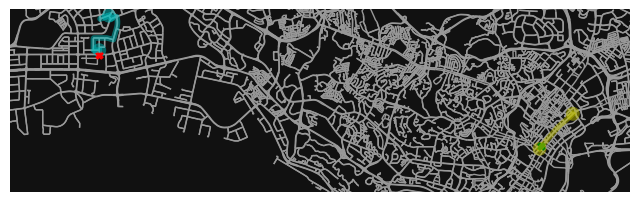

In [83]:
TI = TripItinerary(G_bus, itinerary)
TI.plot_itinerary()

In [84]:
TI = TripItinerary.from_file(G_bus, fp=publicTransit_fp_list[1])
itinerary_entry = TI.get_itinerary_entry()
itinerary_entry

{'start_lat': 1.29684825487647,
 'start_lon': 103.85253591654006,
 'end_lat': 1.3275840581980238,
 'end_lon': 103.70346391036824,
 'actual_bus_duration': 1017.0,
 'simulated_bus_duration': 340,
 'actual_bus_distance': 5171.84,
 'simulated_bus_distance': 5228,
 'actual_total_duration': 3975.0,
 'simulated_total_duration': 3298.0,
 'non_bus_duration': 2958.0,
 'number_of_busroutes': 2}

In [ ]:
noData_file = os.path.join(r'data','error_itineraryEntry_log1.txt')
itinerary_entries = []
for fp in publicTransit_fp_list:
    TI = TripItinerary.from_file(G_bus, fp=fp)
    try:
        itinerary_entry = TI.get_itinerary_entry()
        itinerary_entries.append(itinerary_entry)
    except:
        if not os.path.exists(noData_file):
            with open(noData_file, "w") as myfile:
                myfile.write(f'{fp}\n')

        else:
            with open(noData_file, "a") as myfile:
                myfile.write(f'{fp}\n')

itinerary_df = pd.DataFrame.from_records(itinerary_entries)

In [ ]:
# TODO: create new columns for the start_nearest_nodes and end_nearest_nodes

{'start_lat': 1.29684825487647,
 'start_lon': 103.85253591654006,
 'end_lat': 1.3275840581980238,
 'end_lon': 103.70346391036824,
 'actual_bus_duration': 1017.0,
 'simulated_bus_duration': 340,
 'actual_bus_distance': 5171.84,
 'simulated_bus_distance': 5228,
 'actual_total_duration': 3975.0,
 'simulated_total_duration': 3298.0,
 'non_bus_duration': 2958.0,
 'number_of_busroutes': 2}